---
date: 2022-11-30
title: SSH Model Eigenmodes
date-format: short
---

In this toutorial we want to consider quite easy toy model of polymer which cointein two kinds of atoms per unit site called as a SSH model. It is quite transparent model which simultaneously have a topological properties.


We start with the Hamiltonian which describe our system,

$$H=-\sum_{ i} v (A_{i}^{\dagger}B_{i}+h.c.)-\sum_{j}w(A^{\dagger}_{i}A_{i+1}+B^{\dagger}_{i}B_{i+1}+h.c. ),$$
here $v$ ($w$) is the overlap integral between the atoms in unit cell (betwens cells) and $A_{i}, B_{i}$ $(A_{i}^\dagger, B_{i}^\dagger)$ are a creation (anihilation) operators in $i$-th unit cells rspectivly $A$ and $B$ like site.  

Our basic aim is to presented some common know properties of such a model with the use of additional python's package KWANT.
Forst of all we need to install it in our program by simple commend,


Here we incorporate all functions which we are going to use,

In [1]:
import kwant
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy as scp
import numpy as np
import scipy
from kwant.physics import dispersion
from numpy.linalg import eig

First of all we have to define our system. 

In [18]:
L=50
# Building SSH model
def ssh_model(v=1, w=1, L=50):
    syst = kwant.Builder()
    a = 1
    lat = kwant.lattice.chain(a)

    # Define the scattering region
    for n in range(L):
        syst[lat(n)] = 0

    # Left hopping
    for n in range(L):
        if n % 2:
            syst[lat(n - 1), lat(n)] = v

    # Right hopping
    for n in range(1, L):
        if not n % 2:
            syst[lat(n - 1), lat(n)] = w

    return syst.finalized() 


In our case we put onsite equal to zero. In order to defne our system we establish different hoppings for odd and even sites. For even sites the Hamiltonian part discrebes intercells hoppings is
$$-\sum_{ i} v (A_{i}^{\dagger}B_{i}+h.c.)$$
while for odds we have got
$$-\sum_{j}w(A^{\dagger}_{i}A_{i+1}+B^{\dagger}_{i}B_{i+1}+h.c. )$$

The SSH is the simplest one dimensional model in which one can observed edge states. We can observed this on the folowing plot,


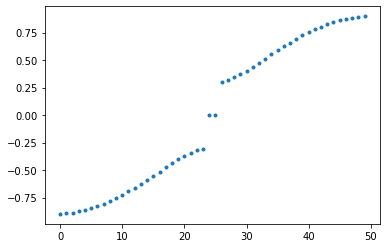

In [19]:
def SSH_energy(v,w):
  syst = ssh_model(w=w, v=v, L=L)
  hamiltonian = syst.hamiltonian_submatrix(sparse=False)
  w1,v1=eig(hamiltonian)
  plt.plot(np.arange(0,L,1),sorted(np.real(w1)),'.')
  plt.show()

#interact(SSH_energy,v=(0,1,0.1),w=(0,1,0.1));
SSH_energy(0.3, 0.6)

Existing of such a states should have visual consequences in density of states (DOS). Ther should appear additional pick in zero energy. We can easy get DOS by using KWANT. Let us look on the following example. 

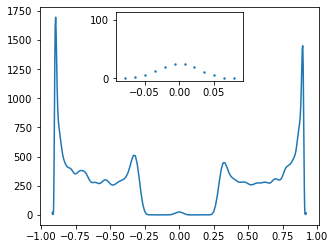

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def plot_DOS3(v,w):
    fig, ax = plt.subplots(figsize=[5, 4])
    syst = ssh_model(w=w, v=v, L=500)
    hamiltonian = syst.hamiltonian_submatrix(sparse=False)

    w1,v1=eig(hamiltonian)
    rho = kwant.kpm.SpectralDensity(hamiltonian, rng=0)
    w1, densities = rho()
    density_subset = np.real(rho(w1))
    ax.plot(w1,density_subset)

    # generate inset axes
    axins = zoomed_inset_axes(ax, 5, loc='upper center')  # zoom = 5

    # plot in the inset axes
    axins.scatter(w1,density_subset, s=2)

    # fix the x, y limit of the inset axes
    axins.set_xlim(-max(w1)/10, max(w1)/10)
    axins.set_ylim(-5, max(density_subset)/15)

    # fix the number of ticks on the inset axes
    axins.yaxis.get_major_locator().set_params(nbins=1)
    axins.xaxis.get_major_locator().set_params(nbins=1)

#interact(plot_DOS3,v=(0.0,5,0.1),w=(0.0,5,0.1))
plot_DOS3(0.3, 0.6)

One can observe that indeed for $w>v$ we have non zero value of DOS around zero energy while $w < v$ we observed platou.



Now we want to plot energy spectrum as a function os hopping parameter $v$ when w is holds constant. We have to identify each energy corespond to a given site. To this end, we used the following procedure. For a given $v$ we find all eigenvalues and eigenstates for every sites. Then we moved to another value of $v$ and do this same. Now to identify which eigenvalues corespond to this same site we chack for every eigenvector from the previous iteration gives us the bigest overlap (the bigest value of scalar product) with one of the state. The prosedure countinous for every value $v$.

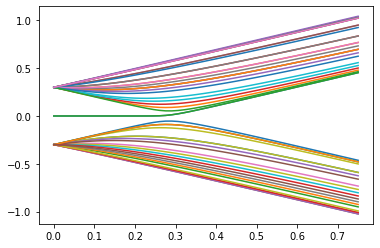

In [22]:
def find_continuator(w: list, next_vectors: list) -> int:
    max_product = np.dot(w, next_vectors[0])
    max_index = 0

    for i in range(len(next_vectors)):
        product = np.abs(np.dot(w, next_vectors[i]))
        if product > max_product:
            max_product = product
            max_index = i
    return max_index

def plot_probability(k_tab: list ,eig_number: int,w,  show_unsorted=False) -> None:
    e_val_matrix = np.empty(shape=(len(k_tab), eig_number))
    e_vec_matrix = np.empty(shape=(len(k_tab), eig_number, L), dtype=complex)

    for i in range(len(k_tab)):
        v = k_tab[i]
        syst = ssh_model(v, w)
        hamiltonian = syst.hamiltonian_submatrix(sparse=False)

        e_val, e_vec = scipy.sparse.linalg.eigsh(
            hamiltonian, k=eig_number, sigma=0.01, which="LM", return_eigenvectors=True
        )

        e_val_matrix[i] = e_val
        for j in range(eig_number):
            e_vec_matrix[i, j] = e_vec[:, j]
            e_vec_matrix[i, j] = e_vec_matrix[i, j] / np.sqrt(
                np.dot(e_vec_matrix[i, j], e_vec_matrix[i, j])
            )

    for j in range(eig_number):
        strip = [e_val_matrix[0, j]]
        vectors = [e_vec_matrix[0, j]]

        for i in range(0, len(k_tab) - 1):
            index = find_continuator(vectors[i], e_vec_matrix[i + 1])
            vectors.append(e_vec_matrix[i + 1, index])
            strip.append(e_val_matrix[i + 1, index])

        plt.plot(k_tab, strip, label=j)
        if show_unsorted:
            plt.scatter(k_tab, e_val_matrix[:, j], marker=".")
            
k = np.linspace(0, 0.75, 50)  # Range of k we want to plot
energies_number = 47  # Number of energy bands to show

#interact(plot_probability, k_tab = fixed(k), w=(0.1,0.5,0.1), eig_number=fixed(energies_number));
plot_probability(k, w=0.3, eig_number=energies_number)

What you can see above is a plot of energy spectrum as a function of parameter $v$. Using by the slider you can change the value of parameter $w$. What is interesting here is that there exist zero energy modes for the parameter values smaller that $w$ which are, as we mentioned earlier, energies of edges states. One can see that zero energy modes are not exacly appear for $w=v$. This is a consequence that we working with the finite system. This incoherence disappear if you put the bigger and bigger size of the system. 

We can easly diagonalize our Hamiltonian by taking Fourier transform,
$$A^{\dagger}_{i}=\frac{1}{\sqrt{N}}\sum_{k}e^{ik\cdot x_{i}} A^{\dagger}_{k} \hspace{0.5cm} \mathrm{etc..}$$
In the end Hamiltonian in momentum space takes form
$$H=\sum_{k}(A^{\dagger}_{k},B^{\dagger}_{k})\begin{pmatrix}
0 & v+e^{ik}w \\
v+e^{-ik}w & 0 
\end{pmatrix}
\begin{pmatrix}
A_{k}  \\
B_{k} 
\end{pmatrix} $$

Now it is easy to find dispersion relation which in this case is given by the following expresion,
$$E(k)=\pm \sqrt{v^2+w^2+2vw\cos{k}} .$$

Now because we have used Fourier transform we tacitly impose boundary conditions. To procedure further we have to build an infinite system. In order to do this, we need to add leads. 

In [23]:
def ssh_model_with_leads(v=1.0, w=0.5):
    L=200
    a=1
    # Start with an empty tight-binding system and a single square lattice.
    # `a` is the lattice constant (by default set to 1 for simplicity.
    syst = kwant.Builder()
    
    lat = kwant.lattice.Polyatomic([[2*a, 0]], [[0, 0], [a, 0]])
    lat.a, lat.b = lat.sublattices
    
    for n in range(L):
        syst[lat.a(n)] = 0
        syst[lat.b(n)] = 0
    
    # Left hopping
    for n in range(L):
        syst[lat.a(n), lat.b(n)] = v
        
    # Left hopping
    for n in range(1,L):
        syst[lat.b(n-1), lat.a(n)] = w

    # Add leads
    sym_left_lead = kwant.TranslationalSymmetry([-2*a, 0])
    left_lead = kwant.Builder(sym_left_lead)
    left_lead[lat.a(0)] = 0
    left_lead[lat.b(0)] = 0
    left_lead[lat.a(0), lat.b(0)] = v
    left_lead[lat.b(0), lat.a(-1)] = w
    syst.attach_lead(left_lead)
    left_lead = left_lead.finalized()

    sym_right_lead = kwant.TranslationalSymmetry([2*a, 0])
    right_lead = kwant.Builder(sym_right_lead)
    right_lead[lat.a(0)] = 0
    right_lead[lat.b(0)] = 0
    right_lead[lat.a(0), lat.b(0)] = v
    right_lead[lat.a(0), lat.a(1)] = w
    syst.attach_lead(right_lead)
           
    syst = syst.finalized()
    
    return syst, left_lead

The KWANT give us a chance to plot an energy spectrum of such a model.

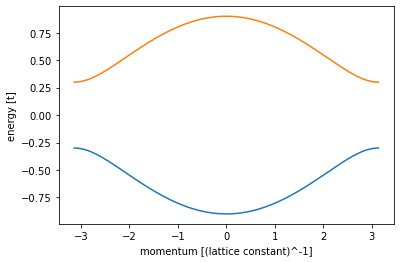

In [24]:
def plot_bandstructure(v,w):
    momenta = np.linspace(-np.pi, np.pi, 200)
    syst, left_lead = ssh_model_with_leads(v=v, w=w)
    bands = kwant.physics.Bands(left_lead)
    energies = [bands(k) for k in momenta]
    
    plt.figure()
    plt.plot(momenta, energies)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    plt.show()

def SSH_spectrum_manipulate_momentum_space(v,w):
  plot_probability(k_tab=k,w=w, eig_number=energies_number)

#interact(plot_bandstructure, v=(0.0,0.5,0.01), w=(0.0,0.5,0.01))
plot_bandstructure(0.3, 0.6)

/usr/local/anaconda3/envs/kwant/lib/python3.6/site-packages/kwant/kpm.py:281: RuntimeWarning: invalid value encountered in sqrt
  g_e = (np.pi * np.sqrt(1 - e) * np.sqrt(1 + e))


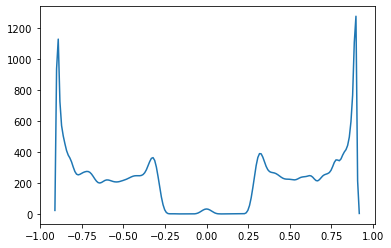

In [27]:
def plot_DOS(v, w):
    momenta = np.linspace(-np.pi, np.pi, 200)
    syst, left_lead=ssh_model_with_leads(v=v, w=w)
    bands = kwant.physics.Bands(left_lead)
    energies = [bands(k) for k in momenta]
    
    rho = kwant.kpm.SpectralDensity(syst,rng=0)
    energies, densities = rho()
    energy_subset = np.arange(-np.pi,np.pi,0.01)
    density_subset = np.real(rho(energy_subset))
    plt.plot(energy_subset,density_subset)
    plt.show()
 
#interact(plot_DOS,v=(0.0,5,0.1),w=(0.0,5,0.1));
plot_DOS(0.3, 0.6)

What you can see above it is a energy spectrum of a Hamiltonian after a Fourier transform. 

In [28]:
def ssh_model_monoatomic_with_leads(v = 1, w = 1, L = 100, return_only_ham = 0):
    
    syst = kwant.Builder()
    a = 1
    lat = kwant.lattice.chain(a)

    # Define the scattering region
    for n in range(L):
        syst[lat(n)] = 0

    # Left hopping
    for n in range(L):
        if n%2:
            syst[lat(n-1), lat(n)] = v

    # Right hopping
    for n in range(1,L):      
        if not n%2:
            syst[lat(n-1), lat(n)] = w

    sym_left_lead = kwant.TranslationalSymmetry([-a])
    left_lead = kwant.Builder(sym_left_lead)
    left_lead[lat(0)] = 0
    left_lead[lat(1), lat(0)] = v
    left_lead[lat(2), lat(1)] = w
    syst.attach_lead(left_lead)
    left_lead_fin = left_lead.finalized()

    sym_right_lead = kwant.TranslationalSymmetry([a])
    right_lead = kwant.Builder(sym_right_lead)
    right_lead[lat(0)] = 0
    right_lead[lat(1), lat(0)] = v
    right_lead[lat(2), lat(1)] = w
    syst.attach_lead(right_lead)
    right_lead_fin = right_lead.finalized()
    
    return syst.finalized()

Let us look at wave function of our system. Is easy to realise that it is apparently hight in the edge of our chain for topological regime.

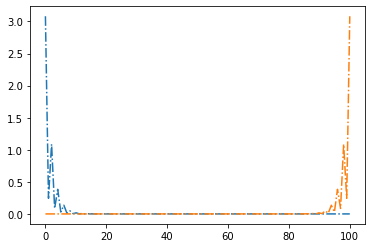

In [32]:
def plot_probability(v,w,energy):
    syst = ssh_model_monoatomic_with_leads(v=v, w=w)
    wf = kwant.solvers.default.wave_function(syst, energy)
    L=100
    p_1 = []
    p_2 = []
    for i in range(len(wf(0)[0])):
        p_1.append(abs(wf(0)[0][i])**2)
        p_2.append(abs(wf(1)[0][i])**2)
    plt.plot(np.linspace(0,L,L), p_1, '-.')
    plt.plot(np.linspace(0,L,L), p_2,  '-.')

#interact(plot_probability,v=(0,0.9,0.01),w=(0,0.9,0.01),energy=(0,1,0.1))
plot_probability(0.3, 0.6, energy=0.2)